# Offer Generation and Compliance Agent

In [1]:
from enum import Enum
from pathlib import Path

from dotenv import load_dotenv
from langchain.agents import AgentExecutor, create_tool_calling_agent, tool
from langchain.output_parsers.enum import EnumOutputParser
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_openai import OpenAIEmbeddings
from langchain_openai.chat_models import ChatOpenAI
from langchain_text_splitters import CharacterTextSplitter, MarkdownHeaderTextSplitter

load_dotenv()

True

## Data Ingestion

### Style Guidelines 

In [2]:
text_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=[
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
    ],
    strip_headers=False
)
texts = text_splitter.split_text(Path("data/style_guidelines_kb.md").read_text())

In [3]:
embeddings = OpenAIEmbeddings()
style_guidelines_db = Chroma.from_documents(texts, embeddings, collection_name="style_guidelines")
style_guidelines_retriever = style_guidelines_db.as_retriever(k=3)

In [4]:
style_guidelines_retriever.invoke("call to action")[0]

Document(metadata={'Header 1': 'IGZ Telecom Style Guide for Generating Promotional Email Offers', 'Header 3': 'Additional Notes'}, page_content='### Additional Notes  \n- Avoid generic phrases like "Act now!" or "Limited-time only!" unless genuinely time-sensitive.\n- Regularly update templates to reflect seasonal or trending campaigns.\n- Ensure all emails comply with legal and privacy standards (e.g., opt-out options).')

### Compliance Guidelines

In [5]:
text_splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=[
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
    ],
    strip_headers=False
)
texts = text_splitter.split_text(Path("data/compliance_guidelines_kb.md").read_text())

In [6]:
embeddings = OpenAIEmbeddings()
compliance_guidelines_db = Chroma.from_documents(texts, embeddings, collection_name="compliance_guidelines")
compliance_guidelines_retriever = compliance_guidelines_db.as_retriever(k=3)

In [7]:
compliance_guidelines_retriever.invoke("misleading claim")[0]

Document(metadata={'Header 2': 'IGZ Telecom Compliance and Risk Guidelines for Promotional Email Offers', 'Header 3': 'Examples of Non-Compliant Content'}, page_content='### Examples of Non-Compliant Content  \n**Example 1: Misleading Claim**\n*"Act now to receive the best deal in the market—guaranteed!"*  \n**Issues:**\n- Unverifiable claim ("best deal in the market").\n- Lack of disclaimer or conditions for the guarantee.  \n**Example 2: Incomplete Terms**\n*"Get a free phone when you switch to IGZ Telecom!"*  \n**Issues:**\n- No mention of plan requirements, trade-in conditions, or other restrictions.')

## Agent

### State

In [8]:
from langgraph.graph import StateGraph, START, END

from pydantic import BaseModel


# The overall state of the graph (this is the public state shared across nodes)
class OverallState(BaseModel):
    customer_insight_report: dict
    num_revisions: int
    style_guidelines: str = None
    compliance_guidelines: str = None
    simulated_customer_feedback: str = None
    compliance_feedback: str = None
    generated_email: str = None
    customer_feedback_revision_required: bool = None
    compliance_revision_required: bool = None
    final_compliance_routing: str = None
    final_compliance_routing_reasoning: str = None

### Nodes

In [9]:
def retrieve_guidelines_node(state: OverallState):
    print("RETRIEVING STYLE GUIDELINES")
    
    def format_docs(docs):
        return "\n\n".join([d.page_content for d in docs])
    
    template = """
    For the following customer, come up with a list of 5 comma separated keywords to query the most
    relevant style guidelines for a peronsalized email in terms of email structure and tone.

    Customer insight report:
    {customer_insight_report}
    """
    prompt = ChatPromptTemplate.from_template(template)
    llm = ChatOpenAI(name="gpt-4o-mini", temperature=0)
    chain = prompt | llm | StrOutputParser() | style_guidelines_retriever | format_docs
    
    style_guidelines = chain.invoke({"customer_insight_report" : state.customer_insight_report})
    
    print("RETRIEVING COMPLIANCE GUIDELINES")
    template = """
    For the following customer, come up with a list of 5 comma separated keywords to query the most
    relevant compliance guidelines for generating a promotional email to ensure it adheres to IGZ Telecom policies.

    Customer insight report:
    {customer_insight_report}
    """
    prompt = ChatPromptTemplate.from_template(template)
    llm = ChatOpenAI(name="gpt-4o-mini", temperature=0)
    chain = prompt | llm | StrOutputParser() | compliance_guidelines_retriever | format_docs
    
    compliance_guidelines = chain.invoke({"customer_insight_report" : state.customer_insight_report})
    
    return {
        "style_guidelines" : style_guidelines,
        "compliance_guidelines" : compliance_guidelines
    }

In [10]:
def generate_email_node(state: OverallState):
    print("GENERATING EMAIL")

    llm = ChatOpenAI(name="gpt-4o-mini", temperature=0)
    prompt = PromptTemplate(
        template="""
        Generate a personalized promotional email subject and content based on the following customer data, available promotions, and style guidelines.
        
        Instructions:
        * Choose the single most relevant promotion based on the customer information
        * Be sure to adhere to the IGZ Telecom style guidelines
        * Do not explicitly mention usage or sentiment, but use them to craft the message and narrative
        * Be sure to address any issues if any
        * Only include the email without any pre or post amble
        
        ## Customer data
        {customer_insight_report}
        
        ## Style guidelines
        {style_guidelines}
        
        ## Compliance guidelines
        {compliance_guidelines}
        """
    )
    chain = prompt | llm | StrOutputParser()
    generated_email = chain.invoke(
        {
            "customer_insight_report" : state.customer_insight_report,
            "style_guidelines" : state.style_guidelines,
            "compliance_guidelines" : state.compliance_guidelines
        }
    )
    
    return {"generated_email" : generated_email}

In [11]:
def review_email_node(state: OverallState):
    
    if state.num_revisions == 0:
        return
    
    print("SIMULATING CUSTOMER RESPONSE")
    
    class CustomerFeedback(BaseModel):
        simulated_customer_feedback: str
        revision_required: bool

    llm = ChatOpenAI(name="gpt-4o-mini", temperature=0).with_structured_output(CustomerFeedback)
    prompt = PromptTemplate(
        template="""
        Act as the customer described in the below customer insight report. How successful
        would this email be? Describe the effectiveness and potential improvements in a few short sentences.
        
        ## Customer data
        {customer_insight_report}
        
        ## Generated email
        {generated_email}
        """
    )
    chain = prompt | llm

    customer_feedback_resp = chain.invoke(
        {
            "generated_email" : state.generated_email,
            "customer_insight_report" : state.customer_insight_report,
        }
    )
    
    print("CHECKING EMAIL COMPLIANCE")
    
    class ComplianceFeedback(BaseModel):
        compliance_feedback: str
        revision_required: bool

    llm = ChatOpenAI(name="gpt-4o-mini", temperature=0).with_structured_output(ComplianceFeedback)
    prompt = PromptTemplate(
        template="""
        You are a legal compliance agent who is tasked with reviewing promotional emails
        to verify they adhere to IGZ Telecom Compliance Guidelines.
        
        ## Customer insight report
        {customer_insight_report}
        
        ## Compliance guidelines
        {compliance_guidelines}
        
        ## Generated email
        {generated_email}
        """
    )
    chain = prompt | llm

    compliance_resp = chain.invoke(
        {
            "customer_insight_report" : state.customer_insight_report,
            "generated_email" : state.generated_email,
            "compliance_guidelines" : state.compliance_guidelines,
        }
    )

    return {
        "simulated_customer_feedback" : customer_feedback_resp.simulated_customer_feedback,
        "customer_feedback_revision_required" : customer_feedback_resp.revision_required,
        "compliance_feedback" : compliance_resp.compliance_feedback,
        "compliance_revision_required" : compliance_resp.revision_required
    }

In [12]:
def should_revise(state: OverallState):
    if state.num_revisions > 0 and (state.customer_feedback_revision_required or state.compliance_revision_required):
        return "revise"
    else:
        return "continue"

In [13]:
def revise_email_node(state: OverallState):
    print("REVISING EMAIL")
    
    llm = ChatOpenAI(name="gpt-4o-mini", temperature=0)
    prompt = PromptTemplate(
        template="""
        Revise the personalized promotional email based on customer data, promotions, style guidelines
        and revised customer input
        
        Instructions:
        * Update the email to better reflect the simulated customer feedback
        * Ensure that the changes do not change the factual accuracy of the available promotions or adherence to sIGZ Telecom style guidelines
        * Do not explicitly mention usage or sentiment, but use them to craft the message and narrative
        * Be sure to address any issues if any
        * Only include the email without any pre or post amble
        
        ## Generated email
        {generated_email}
        
        ## Customer data
        {customer_insight_report}
        
        ## Simulated customer feedback
        {simulated_customer_feedback}
        
        ## Compliance feedback
        {compliance_feedback}
        
        ## Style guidelines
        {style_guidelines}
        
        ## Compliance guidelines
        {compliance_guidelines}
        """
    )
    chain = prompt | llm | StrOutputParser()
    revised_email = chain.invoke(
        {
            "generated_email" : state.generated_email,
            "customer_insight_report" : state.customer_insight_report,
            "style_guidelines" : state.style_guidelines,
            "simulated_customer_feedback" : state.simulated_customer_feedback,
            "compliance_guidelines" : state.compliance_guidelines,
            "compliance_feedback" : state.compliance_feedback
        }
    )

    return {
        "generated_email" : revised_email,
        "num_revisions" : state.num_revisions - 1
    }

In [14]:
def final_review_node(state: OverallState):
    print("FINAL COMPLIANCE REVIEW")
    
    class FinalComplianceCheckEnum(str, Enum):
        PASS = "Automatically send email"
        REVIEW = "Human review before sending email"
        FAIL = "Do not send email, requires manual human intervention"
    
    class FinalComplianceRouting(BaseModel):
        final_compliance_routing: FinalComplianceCheckEnum
        final_compliance_routing_reasoning: str = Field(description="Specific reasons on why compliance routing decision was made with examples if necessary.")
        
    llm = ChatOpenAI(name="gpt-4o-mini", temperature=0).with_structured_output(FinalComplianceRouting)
    prompt = PromptTemplate(
        template="""
        You are a legal compliance agent who is tasked with reviewing the final routing
        of a generated promotional email to send, require review, or fail and recommend
        human intervention.
        
        ## Generated email
        {generated_email}
        
        ## Customer data
        {customer_insight_report}
        
        ## Simulated customer feedback
        {simulated_customer_feedback}
        
        ## Compliance feedback
        {compliance_feedback}
        
        ## Style guidelines
        {style_guidelines}
        
        ## Compliance guidelines
        {style_guidelines}
        """
    )
    chain = prompt | llm
    resp = chain.invoke(
        {
            "generated_email" : state.generated_email,
            "customer_insight_report" : state.customer_insight_report,
            "style_guidelines" : state.style_guidelines,
            "simulated_customer_feedback" : state.simulated_customer_feedback,
            "compliance_guidelines" : state.compliance_guidelines,
            "compliance_feedback" : state.compliance_feedback
        }
    )

    return {
        "final_compliance_routing" : resp.final_compliance_routing,
        "final_compliance_routing_reasoning" : resp.final_compliance_routing_reasoning
    }

### Compile Agent Graph

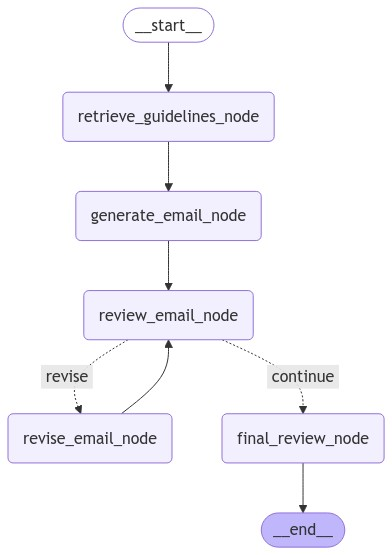

In [15]:
builder = StateGraph(OverallState)
builder.add_node("retrieve_guidelines_node", retrieve_guidelines_node)
builder.add_node("generate_email_node", generate_email_node)
builder.add_node("review_email_node", review_email_node)
builder.add_node("revise_email_node", revise_email_node)
builder.add_node("final_review_node", final_review_node)

builder.add_edge(START, "retrieve_guidelines_node")
builder.add_edge("retrieve_guidelines_node", "generate_email_node")
builder.add_edge("generate_email_node", "review_email_node")
builder.add_edge("revise_email_node", "review_email_node")
builder.add_edge("final_review_node", END)

builder.add_conditional_edges(
    "review_email_node",
    should_revise,
    {"revise" : "revise_email_node", "continue" : "final_review_node"}
)

graph = builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Test Agent

In [16]:
peggy_report = {
    'user_id': 460,
    'customer_name' : "Peggy",
    'account_length': '6 years, 7 months',
    'total_charge_usage': 'medium-low',
    'total_minutes_usage': 'medium',
    'number_customer_service_calls': 5,
    'sentiment_label': 'neutral',
    'account_length_months': 79,
    'churn_likelihood_percentage': 0.464,
    'support_ticket_summary': 'The customer is concerned about the escalating cost of voice services impacting turnover and is looking for alternative options, but hangs up before the TelCom agent can provide further assistance.',
    'available_promotions': [
        'Service Credit: $10 off next bill',
        'Bundle Offer: Add premium channels for $5/month',
        'Anniversary Offer: 1 month free service'
    ]
}
hank_report = {
    'user_id': 2296,
    'customer_name' : "Hank",
    'account_length': '9 years, 9 months',
    'total_charge_usage': 'medium',
    'total_minutes_usage': 'medium',
    'number_customer_service_calls': 2,
    'sentiment_label': 'neutral',
    'account_length_months': 117,
    'churn_likelihood_percentage': 0.01,
    'support_ticket_summary': 'The customer is experiencing slow performance on their phone and is requesting an upgrade, with a technician scheduled to come to their home for the upgrade appointment.',
    'available_promotions': [
        'Bundle Offer: Add premium channels for $5/month',
        'Anniversary Offer: 1 month free service'
    ]
}
bobby_report = {
    'user_id': 1902,
    'customer_name' : "Bobby",
    'account_length': '10 years, 5 months',
    'total_charge_usage': 'high',
    'total_minutes_usage': 'high',
    'number_customer_service_calls': 1,
    'sentiment_label': 'negative',
    'account_length_months': 125,
    'churn_likelihood_percentage': 0.792,
    'support_ticket_summary': 'Customer is frustrated with the poor customer service they have been receiving for their phone, despite not having any issues with the phone itself.',
    'available_promotions': [
        'Retention Offer: 20% discount for 6 months',
        'Loyalty Offer: Free international minutes',
        'Anniversary Offer: 1 month free service'
    ]
}

In [17]:
customer_insight_report = hank_report

In [24]:
%%time
resp = graph.invoke(
    {
        "customer_insight_report": customer_insight_report,
        "num_revisions" : 2
    }
)

RETRIEVING STYLE GUIDELINES
RETRIEVING COMPLIANCE GUIDELINES
GENERATING EMAIL
SIMULATING CUSTOMER RESPONSE
CHECKING EMAIL COMPLIANCE
REVISING EMAIL
SIMULATING CUSTOMER RESPONSE
CHECKING EMAIL COMPLIANCE
REVISING EMAIL
FINAL COMPLIANCE REVIEW
CPU times: user 477 ms, sys: 0 ns, total: 477 ms
Wall time: 13.2 s


In [25]:
print(resp["generated_email"])

Subject: 🎉 Special Anniversary Offer Just for You, Hank! 🎁

Hi Hank,

We value your 9 years and 9 months of loyalty with IGZ Telecom! To express our gratitude, we're thrilled to present you with a special Anniversary Offer: 1 month of free service.

Claim Your Free Month Now!

Don't miss this exclusive opportunity to enjoy an additional month of service at no extra cost. Simply click below to claim your free month and continue enjoying our premium services.

We are committed to providing you with top-notch telecom services and support. If you have any questions about the upgrade you requested for slow performance on your phone, feel free to reach out to us.

Warm regards,
IGZ Telecom


In [26]:
resp["compliance_feedback"]

"The email content meets the compliance guidelines. It accurately presents the Anniversary Offer, includes a clear call-to-action, and maintains a positive tone. The email also respects customer privacy by not including sensitive information and provides an opt-out option. Overall, the email is in compliance with IGZ Telecom's guidelines."

In [27]:
resp["simulated_customer_feedback"]

'The email is well-written and personalized, making me feel valued as a long-time customer. The Anniversary Offer is a nice gesture and the call-to-action is clear. However, I would appreciate more details on the upgrade process for my phone and how the technician appointment will work.'

In [28]:
resp["final_compliance_routing"]

<FinalComplianceCheckEnum.REVIEW: 'Human review before sending email'>

In [29]:
resp["final_compliance_routing_reasoning"]

'The email content meets the compliance guidelines and style guidelines. However, there are specific customer feedback requests for more details on the upgrade process and technician appointment. Human review is recommended to address these requests and ensure customer satisfaction.'

## Gradio UI

In [30]:
import gradio as gr

with gr.Blocks() as demo:
    with gr.Row():
        gr.Markdown("# AI Agent for Predictive Customer Churn")
    with gr.Row():
        user_dropdown = gr.Dropdown(
            [
                ("Peggy", peggy_report),
                ("Hank", hank_report),
                ("Bobby", bobby_report)
            ],
            scale=4
        )
        generate_button = gr.Button("Generate")
    with gr.Row():
        with gr.Column():
            gr.Markdown("## Customer Insight Report")
            customer_name = gr.Text(
                label="Customer Name"
            )
            account_length = gr.Text(
                label="Account Length"
            )
            total_charge_usage = gr.Radio(
                choices=["low", "medium-low", "medium", "medium-high", "high"],
                label="Charge Usage",
            )
            total_minutes_usage = gr.Radio(
                choices=["low", "medium-low", "medium", "medium-high", "high"],
                label="Minutes Usage",
            )
            number_customer_service_calls = gr.Number(
                label="Number Customer Service Calls"
            )
            sentiment_label = gr.Radio(
                choices=["negative", "neutral", "positive"],
                label="Sentiment",
            )
            churn_likelihood_percentage = gr.Slider(
                minimum=0,
                maximum=100,
                label="Churn Likelihood Percentage",
            )
            support_ticket_summary = gr.Text(
                label="Support Ticket Summary"
            )
            available_promotions = gr.Text(
                label="Available Promotions"
            )
            
        with gr.Column():
            with gr.Row():
                with gr.Column():
                    gr.Markdown("## Generated Email")
                    generated_email = gr.Textbox(
                        label=""
                    )
            with gr.Row():
                with gr.Column():
                    gr.Markdown("## Feedback + Routing")
                    simulated_customer_feedback = gr.Text(
                        label="Simulated Customer Feedback"
                    )
                    compliance_feedback = gr.Text(
                        label="Compliance Feedback"
                    )
                    final_compliance_routing = gr.Radio(
                        choices=["pass", "review", "fail"],
                        label="Final Compliance Routing",
                    )
                    final_compliance_routing_reasoning = gr.Text(
                        label="Final Compliance Routing Reasoning"
                    )
                    
            def generate_email(r):
                resp = graph.invoke(
                    {
                        "customer_insight_report": r,
                        "num_revisions" : 1
                    }
                )
                
                return {
                    generated_email: resp["generated_email"],
                    simulated_customer_feedback: resp["simulated_customer_feedback"],
                    compliance_feedback: resp["compliance_feedback"],
                    final_compliance_routing: resp["final_compliance_routing"].name.lower(),
                    final_compliance_routing_reasoning: resp["final_compliance_routing_reasoning"]
                }
            
        def update_customer_insight_report(r):
            if not r:
                return [gr.skip()] * 14
            else:
                return {
                    customer_name: r["customer_name"],
                    account_length: r["account_length"],
                    total_charge_usage: r["total_charge_usage"],
                    total_minutes_usage: r["total_minutes_usage"],
                    number_customer_service_calls: r["number_customer_service_calls"],
                    sentiment_label: r["sentiment_label"],
                    churn_likelihood_percentage: round(r["churn_likelihood_percentage"] * 100, 2),
                    support_ticket_summary: r["support_ticket_summary"],
                    available_promotions: "\n".join([f"• {i}" for i in r["available_promotions"]]),
                    generated_email: None,
                    simulated_customer_feedback: None,
                    compliance_feedback: None,
                    final_compliance_routing: None,
                    final_compliance_routing_reasoning: None
                }

        customer_insight_report_outputs = [
            customer_name, account_length, total_charge_usage, total_minutes_usage,
            number_customer_service_calls, sentiment_label, churn_likelihood_percentage,
            support_ticket_summary, available_promotions
        ]
        
        generate_email_outputs = [
            generated_email, simulated_customer_feedback, compliance_feedback,
            final_compliance_routing, final_compliance_routing_reasoning
        ]

        user_dropdown.change(
            fn=update_customer_insight_report,
            inputs=user_dropdown,
            outputs=customer_insight_report_outputs + generate_email_outputs
        )

        generate_button.click(
            fn=generate_email,
            inputs=user_dropdown,
            outputs=generate_email_outputs
        )

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
IMPORTANT: You are using gradio version 3.50.2, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://fd45a05df17cb0d7f0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
